## Data Acquisition

### Elk

In [130]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import requests
import json
import pprint
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
from scipy.stats import norm
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

########################## put imports in own cell

# creating full urls from base and tails that do not appear in html of main page (allows us to avoid clicking through to sub-urls)
hunt_code = []
short_url = 'https://dwrapps.utah.gov/huntboundary/HaNumber'
hunt_nums_EB = list(range(3000,3129))  #hard code list of limited entry elk hunt numbers

for each in hunt_nums_EB:
    string_EB = str(each)   # change each hunt number int to str for concatenation purposes
    letters_EB = '?hn=EB' + string_EB   # concatenate hunt letter abbreviations with hunt numbers to create full hunt code
    hunt_code.append(short_url + letters_EB)

# creating empty lists of parameters of interests for later population
hunt_number = []
hunt_type = []
species = []
unit_name = []
weapon_type = []
season_dates = []
percent_harvest = []
pop_obj = []
current_pop = []
age_obj = []
current_age = []

# extracting data from urls
for i in hunt_code:
    res = requests.get(i)
    hunt = json.loads(res.text) 

    ### huntBios key
    res.headers['content-type']
    pagedata = res.content.decode("utf-8")
    hunt_num_json = json.loads(pagedata)
    huntBios = hunt_num_json['huntBios'][0]
    man_obj = huntBios['MANAGEMENT_OBJ']
    split = man_obj.split('~') # relevant information is contained in string; splitting string to useable elements
    # creating perent_harvest, pop_obj, current_pop, age_obj, current_age lists by splitting string correctly
    percent_harvest.append(split[0])
    pop_obj.append(split[1])
    current_pop.append(split[2])
    age_obj.append(split[5])
    current_age.append(split[6])
    

    ### huntMaster key
    # creating unit_name, hunt_number_hunt_type, species, and weapon_type lists from huntMaster key
    huntMaster = hunt_num_json['huntMaster']
    unit_name.append(huntMaster['HUNT_NAME'])
    hunt_number.append(huntMaster['HUNT_NBR'])
    hunt_type.append(huntMaster['HUNT_TYPE'])
    species.append(huntMaster['SPECIES'])
    weapon_type.append(huntMaster['WEAPON'])


    ### huntYears key
    # creating season_dates list from the huntYears key
    huntYears = hunt_num_json['huntYears']
    huntYears0 = (huntYears[0])
    szn = huntYears0['SEASON_DATE_TEXT']
    season_dates.append(szn)

# creating dataframe from lists created in last step
df=pd.DataFrame()
df['Unit_Name']=unit_name
df['Hunt_Number']=hunt_number
df['Type']=hunt_type
df['Species']=species
df['Season_Dates']=season_dates
df['Weapon']=weapon_type
df['Hunter_Success']=percent_harvest
df['Pop_Objective']=pop_obj
df['Current_Pop']=current_pop
df['Age_Objective']=age_obj
df['Current_Age']=current_age




# print(unit_name)
# print(hunt_number)
# print(hunt_type)
# print(species)
# print(weapon_type)
# print(percent_harvest)
# print(pop_obj)
# print(current_pop)
# print(age_obj)
# print(current_age)
# print(season_dates)

### Deer

In [96]:
# hunt_nums_DB = list(range(1000,1076))  #hard code list of limited entry deer hunt numbers

# for each in hunt_nums_DB:
#     string_DB = str(each)   # change each hunt number int to str for concatenation purposes
#     letters_DB = '?hn=DB' + string_DB   # concatenate hunt letter abbreviations with hunt numbers to create full hunt code
#     hunt_code.append(short_url + letters_DB)

# # extracting data from urls
# for i in hunt_code:
#     res = requests.get(i)
#     hunt = json.loads(res.text) 

#     ### huntBios key
#     res.headers['content-type']
#     pagedata = res.content.decode("utf-8")
#     hunt_num_json = json.loads(pagedata)
#     huntBios = hunt_num_json['huntBios'][0]
#     man_obj = huntBios['MANAGEMENT_OBJ']
#     split = man_obj.split('~') # relevant information is contained in string; splitting string to useable elements
#     # creating perent_harvest, pop_obj, current_pop, age_obj, current_age lists by splitting string correctly
#     percent_harvest.append(split[0])
#     pop_obj.append(split[1])
#     current_pop.append(split[2])
#     age_obj.append(split[5])
#     current_age.append(split[6])
    

#     ### huntMaster key
#     # creating unit_name, hunt_number_hunt_type, species, and weapon_type lists from huntMaster key
#     huntMaster = hunt_num_json['huntMaster']
#     unit_name.append(huntMaster['HUNT_NAME'])
#     hunt_number.append(huntMaster['HUNT_NBR'])
#     hunt_type.append(huntMaster['HUNT_TYPE'])
#     species.append(huntMaster['SPECIES'])
#     weapon_type.append(huntMaster['WEAPON'])


#     ### huntYears key
#     # creating season_dates list from the huntYears key
#     huntYears = hunt_num_json['huntYears']
#     huntYears0 = (huntYears[0])
#     szn = huntYears0['SEASON_DATE_TEXT']
#     season_dates.append(szn)

# # creating dataframe from lists created in last step
# df=pd.DataFrame()
# df['Unit Name']=unit_name
# df['Hunt Number']=hunt_number
# df['Type']=hunt_type
# df['Species']=species
# df['Season Dates']=season_dates
# df['Weapon']=weapon_type
# df['% Harvest Success']=percent_harvest
# df['Pop Objective']=pop_obj
# df['Current Pop']=current_pop
# df['Age Objective']=age_obj
# df['Current Age']=current_age

# df.head()


## Cleaning

In [131]:
df.head(20)
print(type(df['Pop_Objective'][18]))
print(df['Pop_Objective'][18])
 
df.to_excel('check1.xlsx')
#manually cleaning
# Organize the data by unit name or population estimates. 
#We need to clean the wasatch range data, and then and populations that have a XXX-XXX format.I just take an average to the two
#values. I recommend delete the index column as well. 
#127 is missing a current age value. I copied it from other hunts in the same region. 


#fd is seperate from df. This means we wont have to scrape everytime we want to adjust the code.

############################## put in a markdown cell

<class 'str'>
5000-5900


In [132]:
fd = pd.read_excel(r'check.xlsx', index=False)
#fd.head()

#automatic data cleaning

for j in range(0,len(fd)):
    
    #first, get rid of any characters in the population data set (e.i. 1700 (Entire Beaver unit))
    fd['Pop_Objective'][j]= ''.join(i for i in fd['Pop_Objective'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    fd['Pop_Objective'][j] = float(fd['Pop_Objective'][j])
    fd['Current_Pop'][j]= ''.join(i for i in fd['Current_Pop'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    
    #get rid of the ranges of data (i.e. 1200-1500)
    #instead we take the average value of the range (1200-1500 ----> 1350)
    fd['Current_Pop'][j] = float(fd['Current_Pop'][j])
    q = fd['Age_Objective'][j]
    q = q.split('–')
    #idk what that is, but its not a minus sign
    q[0] = float(q[0])
    q[1] = float(q[1])
    fd['Age_Objective'][j] = sum(q)/len(q)

#set the relevant groups to float dtype from objective dtype    
fd[['Pop_Objective','Current_Pop','Age_Objective','Current_Age']]=fd[['Pop_Objective','Current_Pop','Age_Objective','Current_Age']].astype(float)

fd.head(20)

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\charl\Anaconda3\lib\site-package

,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length
0,"Box Elder, Grouse Creek",EB3128,Limited Entry,Elk,"ALW: Sept 14 - Sept 22, 2019 and Oct 5 - Oct 2...",Multiseason,100.0,675.0,700.0,4.75,5.5,0.303571,43
1,"North Slope, Three Corners",EB3115,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Oct 5 - Oct ...",Multiseason,50.0,700.0,400.0,5.75,5.3,0.202381,49
2,Southwest Desert,EB3123,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,60.0,975.0,1200.0,6.75,7.0,0.226190,57
3,"Beaver, East",EB3102,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1050.0,1450.0,7.75,7.5,0.226190,57
4,"Book Cliffs, Bitter Creek/South",EB3103,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,85.7,7500.0,6300.0,6.75,7.2,0.226190,57


In [174]:
#adding distance from SLC column

Dist = [0]*len(fd)
fd['Dist'] = Dist

names = []
for i in fd['Unit_Name']:
    names.append(i)
    
for i,j in enumerate(fd['Unit_Name']):
    print(i)
    print(j)
    print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
    for k in names:
        print(k)
        if k in j:
            Dist[i] += 347
#     if names[i] in j:
#         Dist[i]+=347
#     if names[i+1] in j:
#         Dist[i]+=308
#     if names[i+2] in j:
#         Dist[i]+=224        
#     if names[i+3] in j:
#         Dist[i]+=188  
#     if names[i+4] in j:
#         Dist[i]+=201
#     if names[i+5] in j:
#         Dist[i]+=77
#     if names[i+6] in j:
#         Dist[i]+=148
#     if names[i+7] in j:
#         Dist[i]+=379
#     if names[i+8] in j:
#         Dist[i]+=384
#     if names[i+9] in j:
#         Dist[i]+=287
#     if names[i+10] in j:
#         Dist[i]+=419
#     if names[i+11] in j:
#         Dist[i]+=422
#     if names[i+12] in j:
#         Dist[i]+=537
#     if names[i+13] in j:
#         Dist[i]+=529
#     if names[i+14] in j:
#         Dist[i]+=632
#     if names[i+15] in j:
#         Dist[i]+=562
#     if names[i+16] in j:
#         Dist[i]+=625
#     if names[i+17] in j:
#         Dist[i]+=577
#     if names[i+18] in j:
#         Dist[i]+=526
#     if names[i+19] in j:
#         Dist[i]+=467
#     if names[i+20] in j:
#         Dist[i]+=417
#     if names[i+21] in j:
#         Dist[i]+=408
#     if names[i+22] in j:
#         Dist[i]+=362
#     if names[i+23] in j:
#         Dist[i]+=233
#     if names[i+24] in j:
#         Dist[i]+=268
#     if names[i+25] in j:
#         Dist[i]+=485
#     if names[i+26] in j:
#         Dist[i]+=335
fd


0
Box Elder, Grouse Creek
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
South

Plateau, Fishlake/Thousand Lakes
South Slope, Diamond Mtn
West Desert, Deep Creek
Central Mtns, Manti
Wasatch Mtns
Box Elder, Grouse Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slop

Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
La Sal, Dolores Triangle
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
Southwest Desert
W

Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Box Elder, Pilot Mtn
25
Beaver, East
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtn

Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
La Sal, Dolores Triangle
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
North Slope, Three Corners
North Slope, Three Corners
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
South Slope, Diamond Mtn
West Desert, Deep Creek
Central Mtns, Manti
Wasatch Mtns
Box Elder, Grouse Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cach

Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Box Elder, Pilot Mtn
40
Panguitch Lake
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, Nort

Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
North Slope, Three Corners
North Slope, Three Corners
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
South Slope, Diamond Mtn
West Desert, Deep Creek
Central Mtns, Manti
Wasatch Mtns
Box Elder, Grouse Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, L

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
W

Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
La Sal, Dolores Triangle
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Centra

Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Box Elder, Pilot Mtn
74
Plateau, Fishlake/Thousand Lakes
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Co

Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
North Slope, Three Corners
North Slope, Three Corners
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
South Slope, Diamond Mtn
West Desert, Deep Creek
Central Mtns, Manti
Wasatch Mtns
Box Elder, Grouse Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns

Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
La Sal, Dolores Triangle
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mil

Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
North Slope, Three Corners
North Slope, Three Corners
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
South Slope, Diamond Mtn
West Desert, Deep Creek
Central Mtns, Manti
Wasatch Mtns
Box Elder, Grouse Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, L

Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
La Sal, Dolores Triangle
Beaver, East
Bo

West Desert, Deep Creek
La Sal, Dolores Triangle
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lakes
San Juan Bull Elk
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
North Slope, Three Corners
North Slope, Three Corners
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
South Slope, Diamond Mtn
West Desert, Deep Creek
Central Mtns, Manti
Wasatch Mtns
Box Elder, Grouse Creek
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Box Elder, Grouse Creek
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Paunsaugunt
Plateau, Boulder/Kaiparowits
Plateau, Fishlake/Thousand Lak

San Juan Bull Elk
South Slope, Diamond Mtn
Southwest Desert
Wasatch Mtns
West Desert, Deep Creek
Box Elder, Pilot Mtn
127
West Desert, Deep Creek
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Box Elder, Grouse Creek
North Slope, Three Corners
Southwest Desert
Beaver, East
Book Cliffs, Bitter Creek/South
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
Oquirrh-Stansbury
Panguitch Lake
Plateau, Boulder/Kaiparowits
San Juan Bull Elk
Central Mtns, Manti
Paunsaugunt
Plateau, Fishlake/Thousand Lakes
Wasatch Mtns
West Desert, Deep Creek
South Slope, Diamond Mtn
Book Cliffs, Little Creek Roadless
Beaver, East
Book Cliffs, Bitter Creek/South
Book Cliffs, Little Creek Roadless
Cache, Meadowville
Cache, North
Cache, South
Central Mtns, Manti
Central Mtns, Nebo
Fillmore, Pahvant
La Sal, La Sal Mtns
Monroe
Mt Dutton
Nine Mile, Anthro
North Slope, Three Corners
Oquirrh-Stansbury
Panguitch Lake
Pa

,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length,Dist
0,"Box Elder, Grouse Creek",EB3128,Limited Entry,Elk,"ALW: Sept 14 - Sept 22, 2019 and Oct 5 - Oct 2...",Multiseason,100.0,675.0,700.0,4.75,5.5,0.303571,43,0
1,"North Slope, Three Corners",EB3115,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Oct 5 - Oct ...",Multiseason,50.0,700.0,400.0,5.75,5.3,0.202381,49,0
2,Southwest Desert,EB3123,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,60.0,975.0,1200.0,6.75,7.0,0.226190,57,0
3,"Beaver, East",EB3102,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1050.0,1450.0,7.75,7.5,0.226190,57,0
4,"Book Cliffs, Bitter Creek/South",EB3103,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,85.7,7500.0,6300.0,6.75,7.2,0.226190,57,0
5,"Cache, Meadowville",EB3105,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,33.3,2300.0,2300.0,4.75,4.8,0.226190,57,0
6,"Cache, North",EB3106,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,2300.0,2300.0,4.75,4.3,0.226190,57,0
7,"Cache, South",EB3107,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,75.0,2300.0,2300.0,6.75,5.1,0.226190,57,0
8,"Central Mtns, Nebo",EB3109,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1450.0,2100.0,6.75,5.7,0.226190,57,0
9,"Fillmore, Pahvant",EB3110,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,1600.0,1500.0,7.75,7.9,0.226190,57,0


### Initial Data Exploration

In [153]:
# descriptive statistics on all the numerical elk data
fd.describe()


,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,70.489922,2848.062016,2646.899225,6.362403,6.279070,0.264027,22.961240
std,25.303464,3048.877733,2686.722285,1.017887,1.024441,0.148080,19.117402
min,0.000000,140.000000,200.000000,4.750000,4.300000,0.086310,9.000000
25%,55.600000,1050.000000,1100.000000,5.750000,5.500000,0.196429,9.000000
50%,75.000000,1600.000000,1500.000000,6.750000,6.200000,0.226190,11.000000
75%,91.700000,2500.000000,2600.000000,6.750000,7.200000,0.261905,27.000000
max,100.000000,12000.000000,11300.000000,7.750000,7.900000,0.833333,69.000000


In [134]:
# initial correlation study on numerical data

correlation = fd.corr()
correlation

,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length
Hunter_Success,1.000000,-0.012462,-0.007076,0.150782,0.310422,0.164387,-0.110561
Pop_Objective,-0.012462,1.000000,0.992617,-0.094621,0.107762,-0.015558,0.007278
Current_Pop,-0.007076,0.992617,1.000000,-0.106284,0.082660,-0.008430,0.007352
Age_Objective,0.150782,-0.094621,-0.106284,1.000000,0.761597,-0.056358,0.001631
Current_Age,0.310422,0.107762,0.082660,0.761597,1.000000,-0.040690,0.003110
Szn_Timing,0.164387,-0.015558,-0.008430,-0.056358,-0.040690,1.000000,-0.256690
Szn_Length,-0.110561,0.007278,0.007352,0.001631,0.003110,-0.256690,1.000000


In [135]:
# sorting data based on number of animals, animal age and % success. if large, trophy bulls are the objective, these 3 categories are important hunt data
fd.sort_values(['Current_Pop', 'Current_Age', 'Hunter_Success'], ascending=[False, False, False])


,Unit_Name,Hunt_Number,Type,Species,Season_Dates,Weapon,Hunter_Success,Pop_Objective,Current_Pop,Age_Objective,Current_Age,Szn_Timing,Szn_Length
18,"Central Mtns, Manti",EB3108,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,12000.0,11300.0,5.75,6.1,0.238095,69
77,"Central Mtns, Manti",EB3126,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,84.6,12000.0,11300.0,5.75,6.1,0.333333,13
87,"Central Mtns, Manti",EB3038,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,83.6,12000.0,11300.0,5.75,6.1,0.196429,9
55,"Central Mtns, Manti",EB3039,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,77.6,12000.0,11300.0,5.75,6.1,0.529762,9
111,"Central Mtns, Manti",EB3084,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,73.0,12000.0,11300.0,5.75,6.1,0.261905,11
31,"Central Mtns, Manti",EB3006,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,37.6,12000.0,11300.0,5.75,6.1,0.086310,27
21,Wasatch Mtns,EB3124,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,87.5,8403.0,7200.0,5.75,6.6,0.238095,69
102,Wasatch Mtns,EB3072,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,76.0,8400.0,7200.0,5.75,6.6,0.196429,9
69,Wasatch Mtns,EB3073,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,69.9,8401.0,7200.0,5.75,6.6,0.529762,9
78,Wasatch Mtns,EB3127,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,62.3,8404.0,7200.0,5.75,6.6,0.333333,13


([<matplotlib.axis.YTick at 0x1d8856816d8>,
 <a list of 7 Text yticklabel objects>)

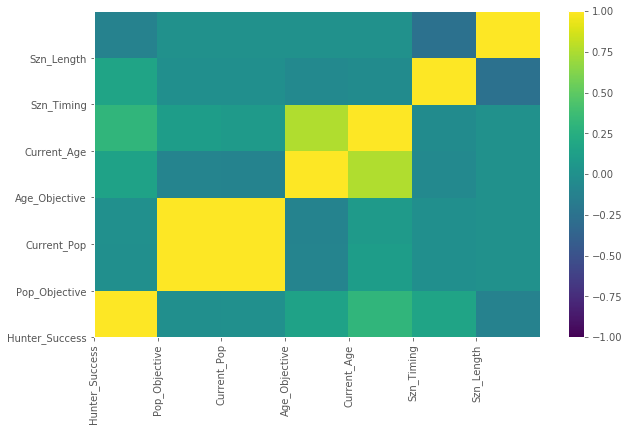

In [136]:
# visualize correlations as matrix

heatmap = plt.pcolor(correlation,vmin=-1,vmax=1)
plt.colorbar(heatmap)


plt.xticks(np.arange(7),('Hunter_Success', 'Pop_Objective','Current_Pop','Age_Objective','Current_Age', 'Szn_Timing', 'Szn_Length'),rotation='vertical')
plt.yticks(np.arange(7),('Hunter_Success', 'Pop_Objective','Current_Pop','Age_Objective','Current_Age', 'Szn_Timing', 'Szn_Length'),rotation='horizontal')

In [151]:
# Regression on hunt success

success =  sm.ols(formula = 'Hunter_Success ~ Current_Pop + Current_Age + Szn_Timing + Szn_Length', data=fd).fit()
success.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Hunter_Success   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     4.772
Date:                Sat, 20 Apr 2019   Prob (F-statistic):            0.00129
Time:                        22:06:25   Log-Likelihood:                -590.10
No. Observations:                 129   AIC:                             1190.
Df Residuals:                     124   BIC:                             1204.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.6592     14.353      1.161      0.248     -11.749      45.067
Current_Pop    -0.0003      0.001     -0.377      0.707      -0.002       0.001
Current_Age     7.8972      2.074      3.808      0.000       3.793      12.002
Szn_Timing     27.1752     14.793      1.837      0.069      -2.104      56.454
Szn_Length     -0.0933      0.114     -0.815      0.417      -0.320       0.133
==============================================================================
Omnibus:                        8.322   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.044
Skew:                          -0.563   Prob(JB):                       0.0179
Kurtosis:                       3.479   Cond. No.                     3.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
# Create a Rank Order System to output top hunting unit

# def User_Preference(trophy):
#     print('On a scale of 1-10, please rate the following:')
#     trophy = int( input("How important is harvesting a large bull elk?: "))
#     freezer = int( input("How important is harvesting any elk?: "))
#     arch = int( input("How important is hunting with a bow?: "))
#     rifle = int( input("How important is hunting with a rifle?: "))
#     muzzy = int( input("How important is hunting with a muzzleloader?: "))
#     length = int( input("How important is having a long hunting season?: "))
#     multi = int( input("How important is the ability to hunt multiple seasons?: "))
#     time = int( input("How important is season timing (enter 0 for early, 5 for middle, 10 for late)?: "))
    
#     for i in 

for i in fd.itertuples():
    print(i)
    print('#################################')


Pandas(Index=0, Unit_Name='Box Elder, Grouse Creek', Hunt_Number='EB3128', Type='Limited Entry', Species='Elk', Season_Dates='ALW: Sept 14 - Sept 22, 2019 and Oct 5 - Oct 27, 2019 Muzz: Sept 23 - Oct 4, 2019', Weapon='Multiseason', Hunter_Success=100.0, Pop_Objective=675.0, Current_Pop=700.0, Age_Objective=4.75, Current_Age=5.5, Szn_Timing=0.30357142857142855, Szn_Length=43)
#################################
Pandas(Index=1, Unit_Name='North Slope, Three Corners', Hunt_Number='EB3115', Type='Limited Entry', Species='Elk', Season_Dates='Arch: Aug 17 - Sept 13, 2019 ALW: Oct 5 - Oct 17, 2019 Muzz: Oct 30 - Nov 7, 2019', Weapon='Multiseason', Hunter_Success=50.0, Pop_Objective=700.0, Current_Pop=400.0, Age_Objective=5.75, Current_Age=5.3, Szn_Timing=0.20238095238095238, Szn_Length=49)
#################################
Pandas(Index=2, Unit_Name='Southwest Desert', Hunt_Number='EB3123', Type='Limited Entry', Species='Elk', Season_Dates='Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Sept 22, 20

### Description of Project Progress

We have acquired most of our data, however during the process we came accross additional data that still needs to be acquired and added to our dataset. We would like to get draw odds of limited entry units, which are only available via pdf right now. We can either manually get data from the pdf, but we are also in the process of contacting the Utah DWR to get the data in a csv form. <br>

Another piece of data that would be nice to acquire is the % of unit that is public land. In the DWR app that we scraped, you can apply filters as map layers that contain public/private land, so this information might be gleanable. 
<br>
If we cannot get this information, then our prject will be a few variables shy of what we proposed.  In that same vein, we haven't figured out a way to get geographical data to show how far each unit is from salt lake city, though we will look into that further as we progress. 

<br>
An important aspect about the dataset is the inclusion of multiple weapon type for each region. Repeats in data are a reflection of this fact and are included in the data set due to the limited permits alloted per weapon type. Once that data is aquired (as mentioned above), the data will become useful. 
<br>
<br>
<br>
Depending if we can get additional data to make our set more robust, we might add the same data we have, but for different species of animals (deer, pronghorn, etc). This will, for the purposes of the project, give us a larger dataset to look at. 
<br>
<br>
Our final analysis will still involve weighting each variable subjectively so we can determine which hunt units are the best. We will also use regression analysis to predic hunter success as well. Another piece that will go into the analysis is we can use the el dataset as a training set, and see if we can predict hunter success in other species (our test sets).  
